#### **Algoritimos Genéticos**
##### **Alexei Alves de Souza**
##### **Matrícula: 398611**
##### **Orientador: José Almeida do Nascimento**

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
%cd 'drive/MyDrive/2020.2/ICA/Notebooks'

[Errno 2] No such file or directory: 'drive/MyDrive/2020.2/ICA/Notebooks'
/content/drive/MyDrive/2020.2/ICA/Notebooks


#### **Problema:**
##### **Determinar  a divisão das unidades de energia de modo a garantir a maior reserva de energia possível nos intervalos especificados.** 

##### **Carrega as tabelas e dados do problema**

In [128]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt


In [129]:
# Tabela com dados da capacidade das unidades em MW  e o número de intervalos em que aparecem.
tabela1 = pd.read_csv("Unity Data And Maintenance.csv")
tabela1

,unity number,unity capacity,number of intervals
0,1,20,2
1,2,15,2
2,3,35,1
3,4,40,1
4,5,15,1
5,6,15,1
6,7,10,1


In [130]:
data = np.array(tabela1)
capacity = data[:,1]
print("Capacity: ", capacity)

Capacity:  [20 15 35 40 15 15 10]


In [131]:
# Cria o pool de genes
one_interval_genes = [1,1<<1,1<<2,1<<3]
two_interval_genes = [3,3<<1,3<<2]

bin_1 = [bin(x) for x in one_interval_genes]
bin_2 = [bin(x) for x in two_interval_genes]

print(" ------------Pool------------")
print('Units [1,2]:',bin_2)
print('Units [3,4,5,6,7]:',bin_1)

 ------------Pool------------
Units [1,2]: ['0b11', '0b110', '0b1100']
Units [3,4,5,6,7]: ['0b1', '0b10', '0b100', '0b1000']


In [132]:
#Cria o vetor de Maximun Loads
max_loads = [80,90,65,70]

##### **Inicializa  a População Inicial**

In [133]:
#Funcao que inicializa a populacao inicial, dados em decimal
#n_pop : inteiro - tamanho da população inicial
def initialize_pop(n_pop):
  pop = []

  for i in range(n_pop):
    two_interval_units = random.choices(two_interval_genes,k = 2)
    one_interval_units = random.choices(one_interval_genes,k=5)
    chromo = two_interval_units + one_interval_units

    pop.append(chromo)
  return pop



In [134]:
initial_pop = initialize_pop(6)
initial_pop

[[6, 3, 4, 1, 4, 4, 2],
 [12, 3, 4, 1, 1, 1, 2],
 [12, 6, 1, 2, 2, 4, 1],
 [12, 3, 2, 4, 8, 8, 8],
 [3, 12, 8, 8, 1, 2, 8],
 [6, 6, 2, 4, 4, 8, 1]]

##### **Analisa a performance de cada cromossomo**

In [135]:
# Função que transforma um vetor de decimais em binário
#v_dec : vetor de inteiros decimais
def decode(v_dec):
  bin_pop = [bin(x)[2:] for x in v_dec]

  for i in range(len(bin_pop)):
    if len(bin_pop[i]) != 4:
      bin_pop[i] = '0'*(4-len(bin_pop[i])) + bin_pop[i]
  return bin_pop


In [136]:
#Funcao que faz a soma da mutiplicação elemento por elemento de dois vetores.
# x,y : vetores de inteiros decimais
def dot(x,y):  
  return sum(map(lambda a,b: a*b,x,y))

In [137]:
#Função que reconstroi os vetores binários dividindo-os de acordo com seus intervalos
#bin_v : vetor de strings de binários
#n_intervals : inteiro - número de intervalos (4)
def decode_to_interval(bin_v,n_intervals):
  intervals = []
  for i in range(n_intervals):
    aux = []
    for bin in bin_v:
      aux.append(int(bin[i]))
    intervals.append(aux)
  return intervals




In [138]:
#Função de avaliação de cada elemento da população
#pop : array - população
#n_pop : inteiro - tamanho da população
#capacity : vetor - capacidade em MW de cada unidade
#total_cap : inteiro - capacidade total do sistema
#max_loads : vetor - máximos loads
#n_intervals : inteiro - número de intervalos
def evaluate(pop,n_pop,capacity,total_cap,max_loads,n_intervals):
  results = []
  for i in range(n_pop):
    bin_pop = decode(pop[i])
    interval = decode_to_interval(bin_pop,n_intervals)
    result = np.sum(interval*capacity,axis = 1)
    result = total_cap - result
    result = result - max_loads
    result = min(result)
    if result <= 0:
      result = 1
    results.append(result)
  return results

#Função para avalir apenas 1 cromossomo
def evaluate_cromossome(chromo,capacity,total_cap,max_loads,n_intervals):
  bin_chromo = decode(chromo)
  interval = decode_to_interval(bin_chromo,n_intervals)
  result = np.sum(interval*capacity,axis = 1)
  result = total_cap - result
  result = result - max_loads
  return result






In [139]:
results = evaluate(initial_pop,6,capacity,150,max_loads,4)
results

[1, 1, 10, 1, 1, 1]

##### **Define os pares para aplicação dos operadores genéticos pela regra da roleta**

In [ ]:
## Roleta que retorna  dois elementos sorteados de um conjunto de dados
#f(xi..n) retorna valores positivos
#results : vetor - performance de cada elemento
def roulette(results):
  total = sum(results)   ## Calcula a soma total
  percents = list(map(lambda x:x/total,results)) ## Calcula as porcentagens em relação a soma total
  index = list(range(len(results))) ##Lista com os indices dos results
  p1 = random.choices(index,weights=percents)[0] ##Escolhe o primeiro dos pais
  p2 = random.choices([x for x in index if x != p1],weights= [percents[i] for i in range(len(percents)) if i!= p1])[0] ## Segundo dos pais

  return p1,p2


In [ ]:
## Aplica a roleta para formar os n/2 pares
#f_results : vetor - performance de cada elemento
#n_pop : inteiro - tamanho da população
def apply_roulette(f_results,n_pop):
  results = f_results.copy()
  pairs = []
  for i in range(n_pop//2):
    p1,p2 = roulette(results)
    pairs.append([p1,p2])
    results[p1] = 0
    results[p2] = 0

  return pairs


In [ ]:
pairs = apply_roulette(results,6)
pairs

[[2, 0], [1, 5], [4, 3]]

##### **Função de Crossover**

In [ ]:
#Função que realiza o crossover
#pop : array - população
#pairs : array - vetores de 2 dimensões(2 pais)
def crossover(pop,pairs,pc):
  sons = []
  n_units = len(pop[0])
  for pair in pairs:
    prob = random.random()
    if prob <= pc:
      cut = random.randint(1,n_units - 1)
      son1 = pop[pair[0]][0:cut] + pop[pair[1]][cut:n_units]
      son2 = pop[pair[1]][0:cut] + pop[pair[0]][cut:n_units] 
    else:
      son1 = pop[pair[0]]
      son2 = pop[pair[1]]
    sons.append(son1)
    sons.append(son2)
  return sons
    


In [ ]:
sons = crossover(initial_pop,pairs,0.7)
sons

[[3, 6, 2, 1, 8, 2, 2],
 [12, 3, 4, 1, 8, 8, 1],
 [3, 3, 8, 4, 1, 4, 1],
 [3, 12, 8, 1, 4, 1, 2],
 [3, 3, 2, 4, 4, 4, 8],
 [3, 12, 4, 1, 8, 1, 2]]

##### **Função de Mutação**

In [ ]:
#Função que realiza as mutações no cromossomo
#pop : array - população
#pm : probabilidade de mutação
def mutate(pop,pm):
  n_units = len(pop[0])
  for p  in pop:
    for n in range(n_units):
      prob = random.random()
      if prob <= pm:
        if n==0 or n==1:
          posible_choices = [x for x in two_interval_genes if x!=p[n]]
        else:
          posible_choices = [x for x in one_interval_genes if x!=p[n]]
        gene = random.choice(posible_choices)
        p[n] = gene
  return pop




In [ ]:
sons = mutate(sons,0.01)
sons

[[3, 6, 2, 1, 8, 2, 2],
 [12, 3, 4, 1, 8, 8, 1],
 [3, 3, 8, 4, 1, 4, 1],
 [3, 12, 8, 1, 4, 1, 2],
 [3, 3, 2, 4, 4, 4, 8],
 [3, 12, 2, 1, 8, 1, 2]]

##### **Geração da nova população**

In [ ]:
#Análise da performance dos filhos
sons_results = evaluate(sons,6,capacity,150,max_loads,4)
sons_results

[1, 5, 5, 5, 1, 5]

In [ ]:
#Função que gera a nova população
#results : vetor - resultados dos pais
#sons_results : vetor - resultados dos filhos
#pop : array - população de pais
#pop : array - população de filhos
def new_generation(results,sons_results,pop,sons):
  new_pop = []
  n_pop = len(results)  
  
  total_results = results + sons_results
  indexes = np.argsort(total_results)[::-1]
  indexes = indexes[0:n_pop]

  for idx in indexes :
    if idx >= n_pop:
      pos = idx - n_pop
      new_pop.append(sons[pos])
    else :
      new_pop.append(pop[idx])
  return new_pop
    


In [ ]:
new_pop = new_generation(results,sons_results,initial_pop,sons)
new_pop

[[3, 6, 2, 1, 8, 8, 1],
 [3, 12, 2, 1, 8, 1, 2],
 [3, 12, 8, 1, 4, 1, 2],
 [3, 3, 8, 4, 1, 4, 1],
 [12, 3, 4, 1, 8, 8, 1],
 [12, 3, 4, 1, 8, 2, 2]]

In [ ]:
new_pop_results = evaluate(new_pop,6,capacity,150,max_loads,4)
new_pop_results

[10, 5, 5, 5, 5, 5]

##### **Criação do Modelo**

In [ ]:
class GA(object):
  def __init__(self):
    ### Valores que são fixos:
    self.max_loads = np.array([80,90,65,70])
    self.capacity = np.array([20,15,35,40,15,15,10])
    self.total_cap = 150
    self.n_interval = 4

  
  def fit(self,n_iter,n_pop,pc,pm):
    self.n_iter = n_iter
    self.n_pop = n_pop
    self.pc = pc
    self.pm = pm
    pop = initialize_pop(self.n_pop)
    self.fitness_history = []
    self.fitness = 0
    self.result = []
    for i in range(n_iter):
      #Calcula a performance da população
      results = evaluate(pop,self.n_pop,self.capacity,self.total_cap,self.max_loads,self.n_interval)

      #Calcula os pares pela regra da roleta
      pairs = apply_roulette(results,self.n_pop)

      #Gera o conjunto de filhos pelos operadores genéticos
      sons = crossover(pop,pairs,pc)
      sons = mutate(sons,pm)
      #Calcula a performance dos filhos
      sons_results = evaluate(sons,self.n_pop,self.capacity,self.total_cap,self.max_loads,self.n_interval)

      #Obtém a nova geração
      new_pop = new_generation(results,sons_results,pop,sons)

      #Obtém o valor médio da nova geração
      new_pop_results = evaluate(new_pop,self.n_pop,self.capacity,self.total_cap,self.max_loads,self.n_interval)
      avg_result = np.mean(new_pop_results)  

      #Salva os dados da iteração
      self.fitness_history.append(avg_result)
      self.result = new_pop[0]
      self.fitness = new_pop_results[0]
      

      pop = new_pop


In [ ]:
ga = GA()

In [ ]:
ga.fit(100,50,0.7,0.001)

In [ ]:
print("Fitness:",ga.fitness,"MW")

Fitness: 25 MW


In [ ]:
print("Melhor Cromossomo:",decode(ga.result))

Melhor Cromossomo: ['1100', '1100', '0001', '0010', '0001', '0010', '1000']


In [ ]:
net_reserves = evaluate_cromossome(ga.result,ga.capacity,ga.total_cap,ga.max_loads,ga.n_interval)
print("Net Reserves", list(net_reserves))

Net Reserves [25, 25, 30, 30]


Text(0, 0.5, 'Fitness')

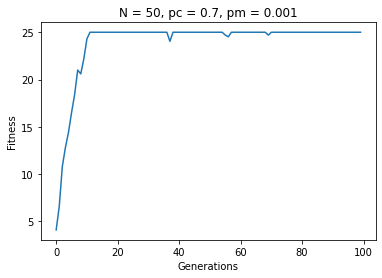

In [ ]:
iter = list(range(0,ga.n_iter))
fitness_history = ga.fitness_history

plt.plot(iter,fitness_history)
plt.title("N = 50, pc = 0.7, pm = 0.001")
plt.xlabel("Generations")
plt.ylabel("Fitness")

##### **Discussão do resultado**
#### **A solução obtida foi :**
#### N° iterações: 100, N° População: 50
##### *Melhor Cromossomo: [1100, 1100, 0001, 0010, 0001, 0010, 1000]*
#### **Distribuição:**
##### *Intervalo I (Unit 1, Unit 2, Unit 7)* NR = 25
##### *Intervalo II (Unit 1, Unit 2)* NR = 25
##### *Intervalo III (Unit 4, Unit 6)* NR = 30*
##### *Intervalo IV (Unit 3, Unit 5)* NR = 30*